In [1]:
%matplotlib notebook
import os
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
import torch.utils.data as td
import torchvision as tv
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import nntools as nt

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [66]:
class NNRegressor(nt.NeuralNetwork):
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.MSE = nn.MSELoss(size_average=None, reduce=None, reduction='sum')
    def criterion(self, y, d):
        return self.MSE(y, d)

In [67]:
vgg = tv.models.vgg16(pretrained=True)

In [68]:
class VGGTransfer(NNRegressor):
    def __init__(self, fine_tuning=False): #want to keep existing weights/biases
        super(VGGTransfer, self).__init__()
        vgg = tv.models.vgg16(pretrained=True)
        for param in vgg.parameters():
            param.requires_grad = fine_tuning
        
        self.net = nn.ModuleList()
        self.net = vgg.features
 
    def forward(self, x):
        rep = {}
        rep['r12'] = self.net[:4](x)
        rep['r22'] = self.net[:9](x)
        rep['r33'] = self.net[:16](x)
        rep['r43'] = self.net[:23](x)

        
        
        return rep #

In [81]:
class ImageTransform(NNRegressor):
    def __init__(self):
        super(ImageTransform, self).__init__()
    
        self.pad = torch.nn.ReflectionPad2d(40)
        self.conv1 = torch.nn.Conv2d(3,32,9)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32,64,3,stride=2)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.conv3 = torch.nn.Conv2d(64,128,3,stride=2)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.res1 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res2 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res3 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.res4 = nn.Sequential(
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            torch.nn.Conv2d(128,128,3),
            torch.nn.BatchNorm2d(128)
        )
        self.conv4 = torch.nn.Conv2d(128,64,3,stride=0.5)
        self.bn4 = torch.nn.BatchNorm2d(64)
        self.conv5 = torch.nn.Conv2d(64,32,3,stride=0.5)
        self.bn5 = torch.nn.BatchNorm2d(32)
        self.conv6 = torch.nn.Conv2d(32,3,9)
        self.tanh = torch.nn.Tanh()
        
    def forward(self, x):
        h = self.pad(x)
        h = F.relu(self.bn1(self.conv1(h)))
        h = F.relu(self.bn2(self.conv2(h)))
        h = F.relu(self.bn3(self.conv3(h)))
        h = F.relu(h + self.res1(h))
        h = F.relu(h + self.res2(h))
        h = F.relu(h + self.res3(h))
        h = F.relu(h + self.res4(h))
        h = F.relu(self.bn4(self.conv4(h)))
        h = F.relu(self.bn5(self.conv5(h)))
        h = self.conv6(h)
        y = (self.tanh(h) + 1) * 255 / 2 # scaled tanh from paper
        return y
ImageTransformNet = ImageTransform()
for param in ImageTransformNet.parameters():
    param.requires_grad = True

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [80]:
print(ImageTransformNet)

ImageTransform(
  (MSE): MSELoss()
  (pad): ReflectionPad2d((40, 40, 40, 40))
  (conv1): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res1): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (res2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentu

In [7]:
datasetTrainDir = "/datasets/COCO-2015/train2014"
datasetTestDir = "/datasets/COCO-2015/val2014"

In [8]:
class COCODataset(td.Dataset):
    def __init__(self, root_dir, mode = 'train', image_size=(256, 256)):
        super(COCODataset, self).__init__()
        self.image_size = image_size
        self.images_dir = os.path.join(root_dir)
        self.files = os.listdir(self.images_dir)
        self.mode = mode
    def __len__(self):
        return len(self.files)
    def __repr__(self):
        return "COCODataset(mode={}, image_size={})". \
            format(self.mode, self.image_size)
    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.files[idx])
        clean = Image.open(img_path).convert('RGB')
        i = np.random.randint(clean.size[0] - self.image_size[0])
        j = np.random.randint(clean.size[1] - self.image_size[1])
        transform = tv.transforms.Compose([
            tv.transforms.Resize(self.image_size),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5)) #given range [0,1] for all channels
            ])
        clean = transform(clean)
        return clean

<IPython.core.display.Javascript object>


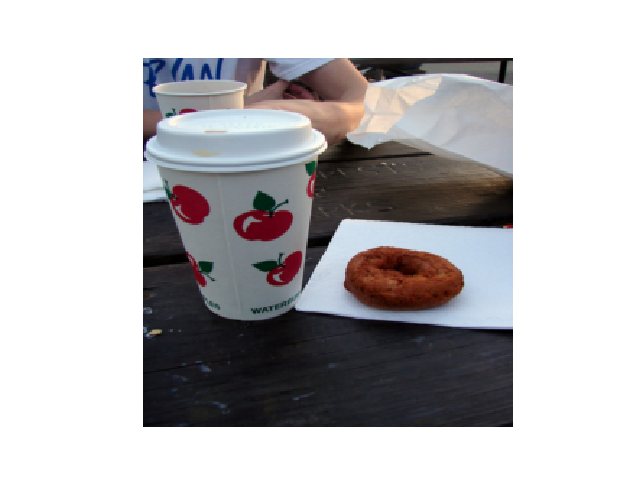

In [13]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

train_set = COCODataset(datasetTrainDir)
test_set = COCODataset(datasetTestDir)

x = train_set.__getitem__(10)
myimshow(x)

In [10]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [11]:
class DenoisingStatsManager(nt.StatsManager):
    def __init__(self):
        super(DenoisingStatsManager, self).__init__()
    def init(self):
        super(DenoisingStatsManager, self).init()
        self.running_PSNR = 0
    def accumulate(self, loss, x, y, d):
        super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
        _, l = torch.max(y, 1)
        n = torch.numel(y)
        self.running_PSNR += 10*torch.log10(4*n/(torch.norm(y-d,2))**2)
    def summarize(self):
        loss = super(DenoisingStatsManager, self).summarize()
        PSNR = self.running_PSNR / self.number_update
        return {'loss': loss, 'PSNR': PSNR}

In [14]:
net = ImageTransform()
net = net.to(device)
stats_manager = DenoisingStatsManager()
adam = torch.optim.Adam(net.parameters(), lr=1e-3)
exp1 = nt.Experiment(net, train_set, test_set, adam, stats_manager,
            output_dir="johnson1", batch_size=4, perform_validation_during_training=False)

In [83]:
vgg = VGGTransfer()

In [93]:
# exp1.run(num_epochs=2)
# print(vgg)
transform = tv.transforms.Compose([
            tv.transforms.Resize((256,256)),
            tv.transforms.ToTensor(),
            tv.transforms.Normalize((.5,.5,.5),(.5,.5,.5)) #given range [0,1] for all channels
            ])
photo_path = 'photo1.jpg'
photo = Image.open(photo_path)
p = transform(photo)
p = p[None,:,:,:] # add a singleton dimension for the batch size

p = p.to(device)
net = VGGTransfer().to(device)

A = net.forward(p)
pt = A['r43']

In [94]:
pt.shape

torch.Size([1, 512, 32, 32])

In [84]:
def Gram(featresp):
    return torch.mm(featresp,featresp.t()) # NlxNl (from paper)

In [95]:
# run and train
optimizer = torch.optim.Adam(ImageTransformNet.parameters(), lr=0.001)

for epochs in range(2):
    for i in range(40000):
        contentimage = train_set.__getitem__(i)
        yhat = ImageTransformNet(contentimage) #x and yc are the same
        # yhat through vgg
        yhatout12 = vgg[:4](yhat).view(64,-1) #relu12
        yhatout22 = vgg[:9](yhat).view(128,-1) #relu22
        yhatout33 = vgg[:16](yhat).view(256,-1) #relu33
        yhatout43 = vgg[:23](yhat).view(512,-1) #relu43
        
        # content losses
        contentout33 = vgg[:16](contentimage).view(256,-1) #relu33
        #2matrix norm?
        contentloss = torch.norm(countentout33 - yhatout33)/(256*64*64)
        
        # style losses
        styleout12 = vgg[:4](styleimage).view(64,-1) #relu12
        styleout22 = vgg[:9](styleimage).view(128,-1) #relu22
        styleout33 = vgg[:16](styleimage).view(256,-1) #relu33
        styleout43 = vgg[:23](styleimage).view(512,-1) #relu43

        #get style gram matrices
        gram1 = Gram(yhatout12)/(64*256*256)
        gram2 = Gram(yhatout22)/(128*128*128)
        gram3 = Gram(yhatout33)/(256*64*64)
        gram4 = Gram(yhatout43)/(512*32*32)
        #get yhat grams
        gram1o = Gram(styleout12)/(64*256*256)
        gram2o = Gram(styleout22)/(128*128*128)
        gram3o = Gram(styleout33)/(256*64*64)
        gram4o = Gram(styleout43)/(512*32*32)
        
        #get frobenius square norm
        l1 = torch.norm(gram1-gram1o)**2
        l2 = torch.norm(gram2-gram2o)**2
        l3 = torch.norm(gram3-gram3o)**2
        l4 = torch.norm(gram4-gram4o)**2

        #total style loss
        styleloss = (l1+l2+l3+l4)/4

        #get total loss
        loss = contentloss + 50000*styleloss

        #backprop
        loss.backward(retain_graph=True)

        #parameter search
        optimizer.step()





















AssertionError: 3D tensors expect 2 values for padding